In [1]:
import sys
sys.path.append("/Users/nikita/Desktop/Test Assigment tabby")


from src.dataloader import DataLoader
from src.estimator import ModelEvaluator

import numpy as np
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import shap
import optuna


import warnings

warnings.filterwarnings("ignore")


In [2]:
with open('/Users/nikita/Desktop/Test Assigment tabby/data/best_cols.pkl', 'rb') as f:
    best_features = pickle.load(f)

dl = DataLoader(path_to_data="/Users/nikita/Desktop/Test Assigment tabby/data/clear_dataset.csv",
                time_column='sample_date',
                threshold_cat_feature=5,
                drop_disbalance=None)

X_train, X_test, y_train, y_test = dl.run()

total_samples = len(y_train)
class_weight_0 = total_samples / (2 * np.bincount(y_train)[0])
class_weight_1 = total_samples / (2 * np.bincount(y_train)[1])

class_weights = {0: class_weight_0, 1: class_weight_1}

### Interpret weights of Logistic Regression


Metrics:   train test
ROC_AUC:   0.744 0.736
Gini:      0.488 0.473
F1_score:  0.294 0.277
Log_loss:  11.048 10.935


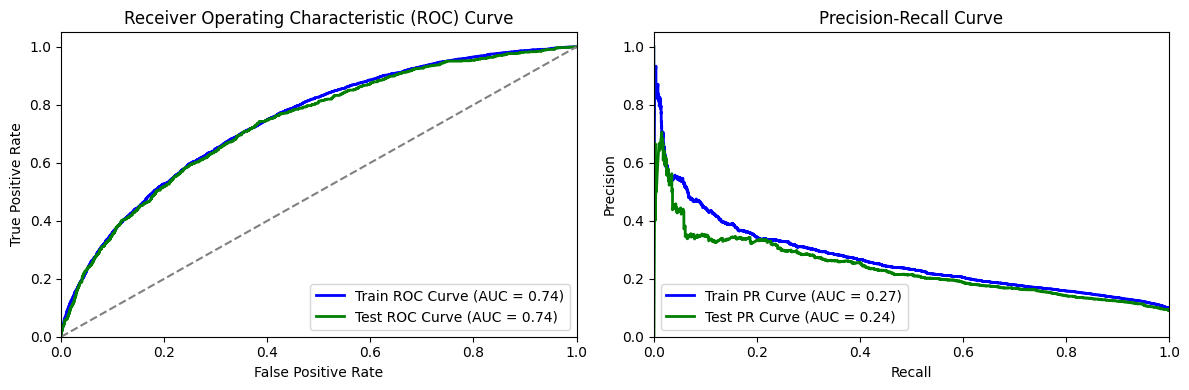

In [3]:
model = LogisticRegression(class_weight=class_weights)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[best_features])
X_test_scaled = scaler.transform(X_test[best_features])
evaluator = ModelEvaluator(model)
model = evaluator.run(X_train_scaled, X_test_scaled, y_train, y_test)

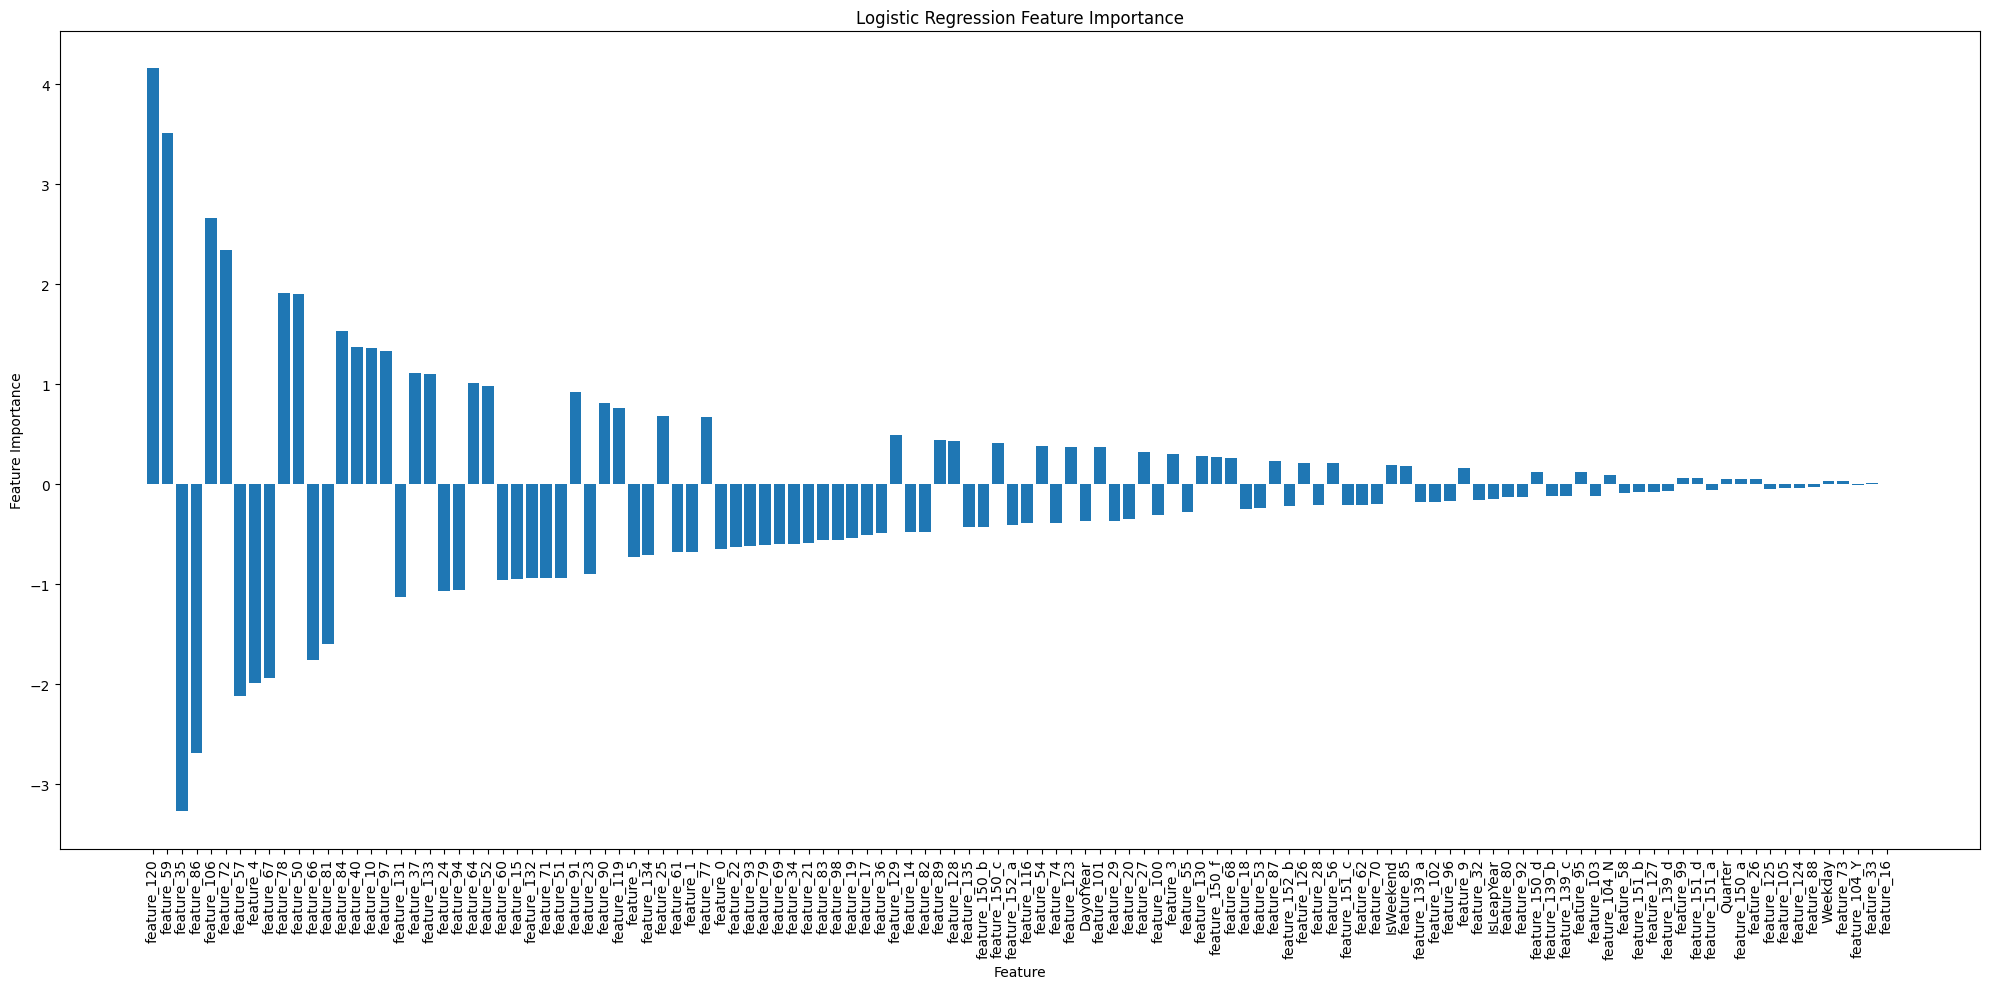

In [4]:
feature_importance = model.coef_[0]
sorted_idx = np.argsort(np.abs(feature_importance))[::-1]

sorted_feature_names = X_train.columns[sorted_idx]
sorted_feature_importance = feature_importance[sorted_idx]

plt.figure(figsize=(20, 10))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align="center")
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()

plt.show()

### Feature importance of lightGBM

Metrics:   train test
ROC_AUC:   0.977 0.771
Gini:      0.954 0.542
F1_score:  0.645 0.343
Log_loss:  3.786 6.275


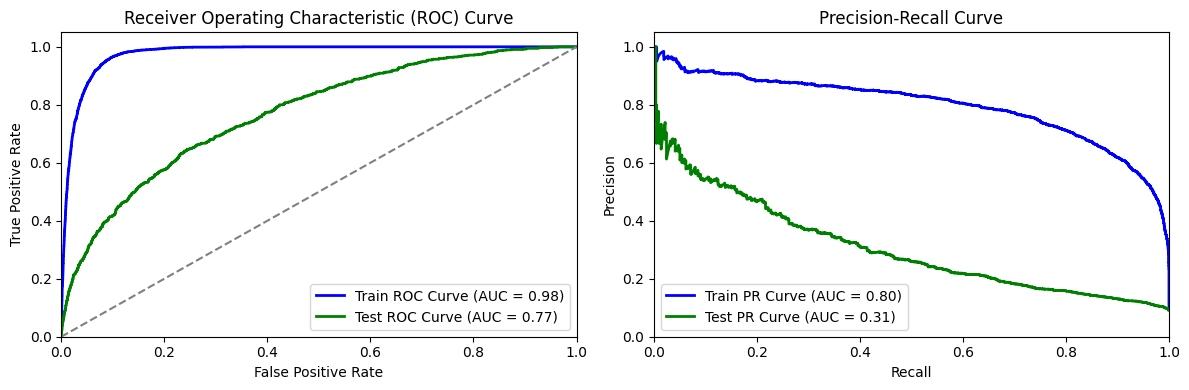

In [5]:
params = {"num_leaves": 93,
          "learning_rate": 0.0567411581353529,
          "feature_fraction": 0.5093894964503696,
          "bagging_fraction": 0.9761155911592959,
          "bagging_freq": 3,
          "max_depth": 16,
          "min_child_samples": 18}
model = lgb.LGBMClassifier(verbose=-1, class_weight=class_weights, **params)
evaluator = ModelEvaluator(model)
model = evaluator.run(X_train[best_features], X_test[best_features], y_train, y_test)

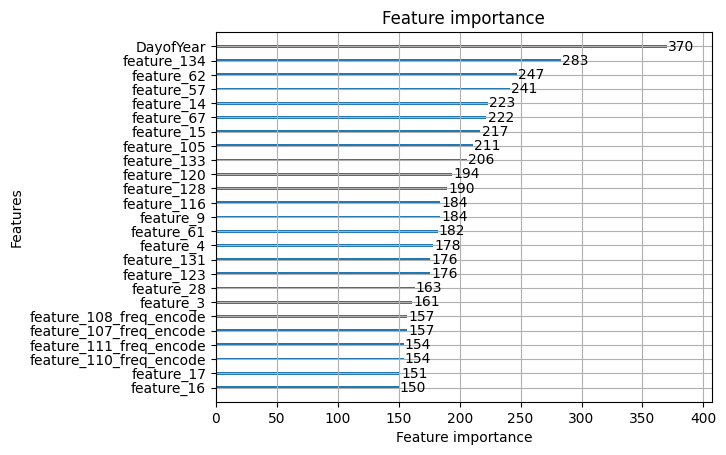

In [6]:
lgb.plot_importance(model, max_num_features=25)  # Set max_num_features as needed
plt.show()

### SHAP

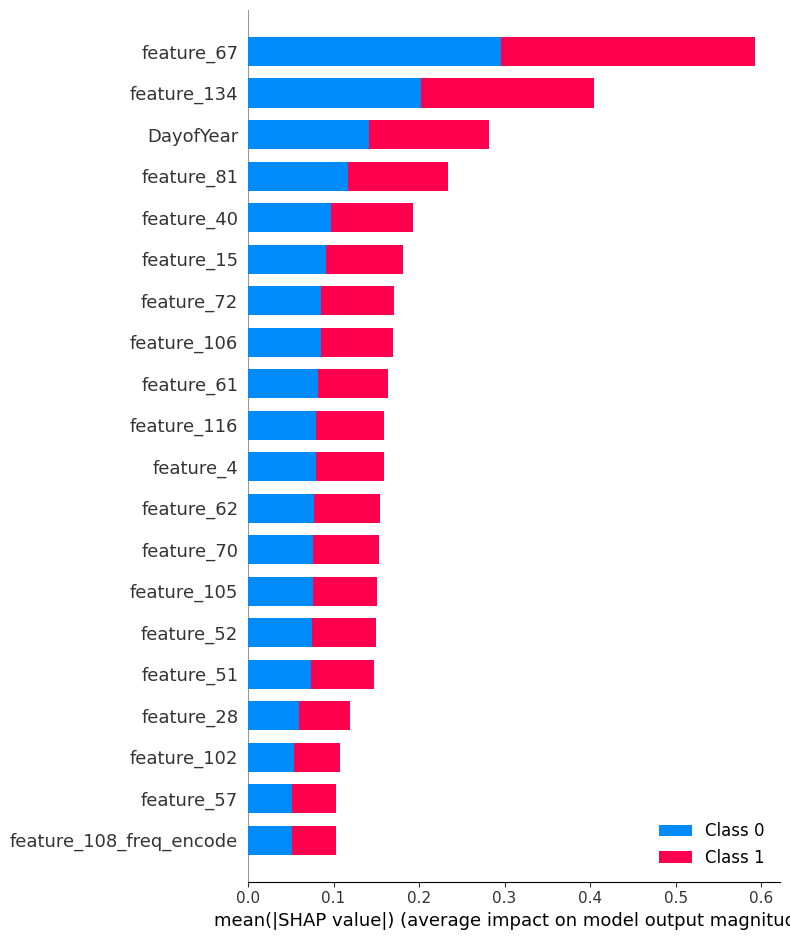

In [9]:

explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test[best_features]) 

shap.summary_plot(shap_values, X_test[best_features], plot_type="bar")
plt.show()

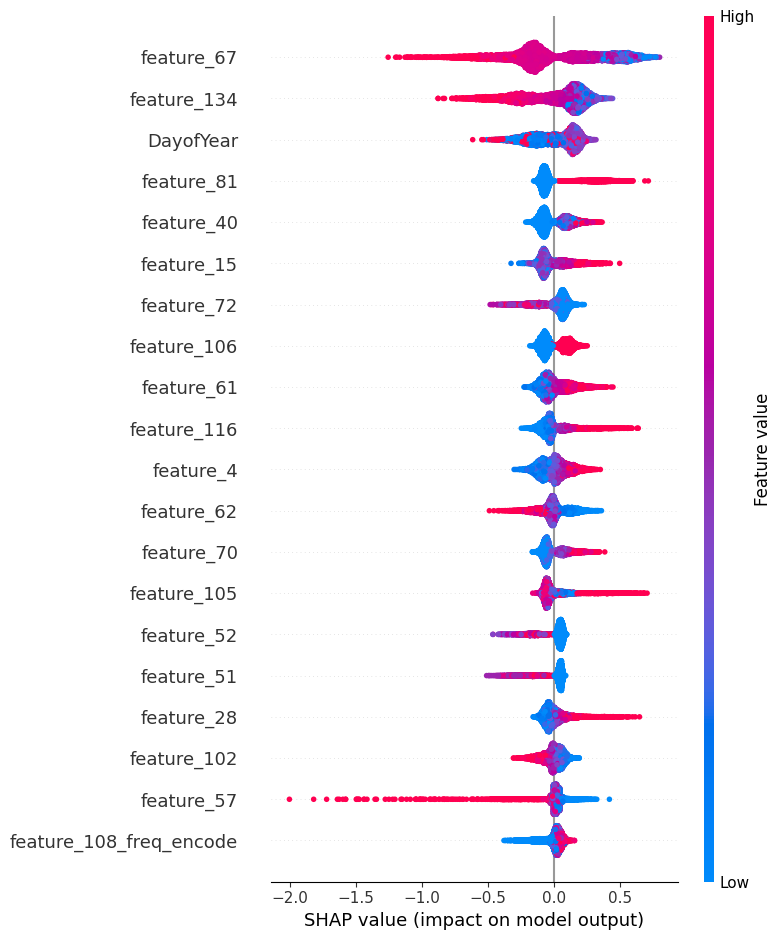

In [17]:
shap.summary_plot(shap_values[0], X_test[best_features])



### ALE

In [18]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from alepython import ale_plot

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /private/var/folders/cb/n7klvybs09g2ycl4j5z4b5800000gn/T/pip-install-6bv316sr/alepython_edee3d7e19c548f8a72318a48aa4c653
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /private/var/folders/cb/n7klvybs09g2ycl4j5z4b5800000gn/T/pip-install-6bv316sr/alepython_edee3d7e19c548f8a72318a48aa4c653
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for loguru>=0.4.1 from https://files.pythonhosted.org/packages/03/0a/4f6fed21aa246c6b49b561ca55facacc2a44b87d65b8b92362a8e99ba202/loguru-0.7.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 158.8 kB/s eta 0:00:00a 0:00:01
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15140 sha256=22b38affd20c5555540db7104be7ac2

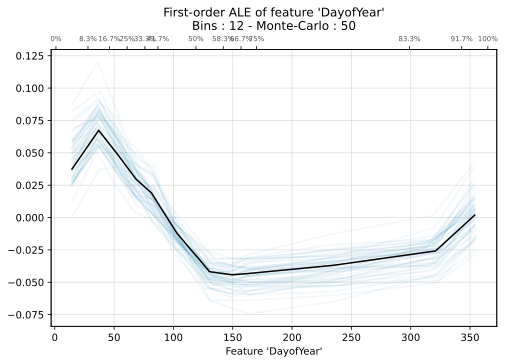

<Axes: title={'center': "First-order ALE of feature 'DayofYear'\nBins : 12 - Monte-Carlo : 50"}, xlabel="Feature 'DayofYear'">

In [31]:
ale_plot(model=model, 
         train_set=X_train[best_features].sample(5000), 
         features='DayofYear', 
         bins=12, 
         monte_carlo=True, 
         monte_carlo_rep=50,
         monte_carlo_ratio=0.6);


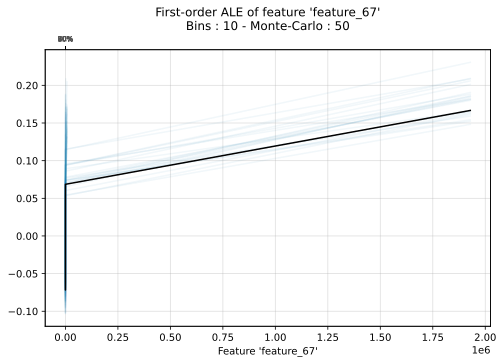

In [33]:
ale_plot(model=model, 
         train_set=X_train[best_features].sample(5000), 
         features='feature_67', 
         bins=12, 
         monte_carlo=True, 
         monte_carlo_rep=50,
         monte_carlo_ratio=0.6);


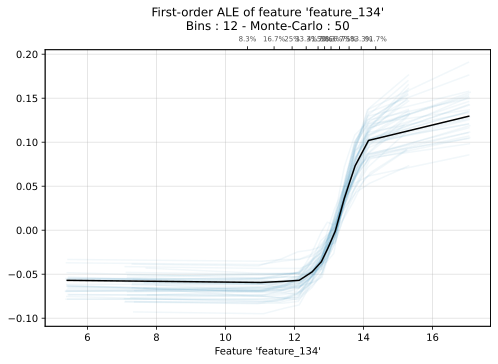

In [54]:
ale_plot(model=model, 
         train_set=X_train[best_features].sample(5000), 
         features='feature_134', 
         bins=12, 
         monte_carlo=True, 
         monte_carlo_rep=50,
         monte_carlo_ratio=0.6);
